
# 프로젝트 10: 인물 모드 문제점 찾기

#### step1. 인물모드 직접 구현하기
#### step2. 사진에서 문제점 찾기
#### step3. 해결 방법 제안

## Step 1. 인물모드 직접 구현하기
- 1) 셀카
- 2) 동물
- 3) 심화 - 크로마키

### 1. 셀카 아웃포커싱 구현

#### 0. import library and define Global variables

In [147]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

#### 1. load DeepLab3 and img

In [148]:
#deeplabv3 모델 다운로드 함수
def deeplabv3_downlaod():
    model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
    model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
    # PixelLib가 제공하는 모델의 url입니다
    model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 
    # 다운로드를 시작합니다
    urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

    model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
    model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출
    return model

(1083, 1440, 3)


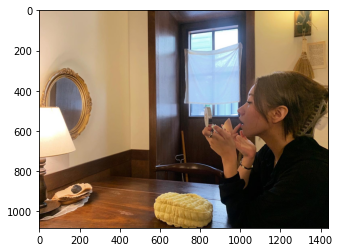

In [102]:
# 이미지 로드
img_path = os.getenv('HOME')+'/aiffel/workplace_1/231005/modulab-AIFELL_Quest/exploration_05/askjfhglhgkljqap.jpg'  
img_orig = cv2.imread(img_path) 
print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

#### 2. Segmenting and Show

In [103]:
segvalues, output = model.segmentAsPascalvoc(img_path) # segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용

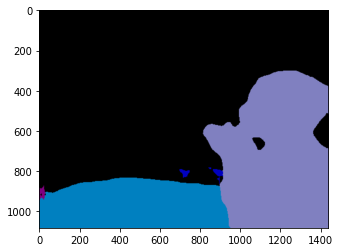

background
bottle
chair
diningtable
person


In [104]:
#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output)
plt.show()

segvalues # segmentAsPascalvoc() 함수를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 배열값을 출력

#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

#### 2-2. Check Color map each OBJ
- 여기서는 사람('person')만 체크
- 사람 인덱스가 하드코딩되어 있음 -> 검색할 수 있도록 3단계에서 함수 따로 구현

In [105]:
#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [106]:
colormap[15] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

array([192, 128, 128])

In [107]:
seg_color_person = (128,128,192) # 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서

(1083, 1440)


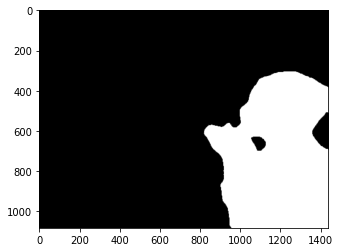

In [108]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = np.all(output==seg_color_person, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

#### 3. Sinthesis - seg_map & origin

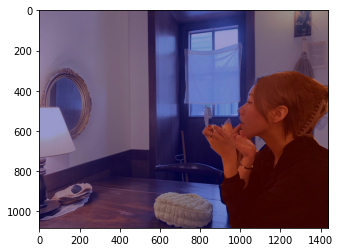

In [109]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

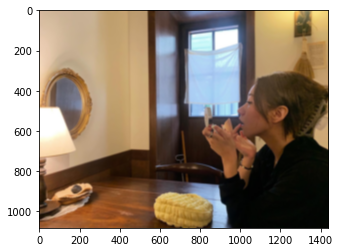

In [110]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur_0 = cv2.blur(img_orig, (40,40)) 
plt.imshow(cv2.cvtColor(img_orig_blur_0, cv2.COLOR_BGR2RGB))
plt.show()

#### 4. Make bluring background

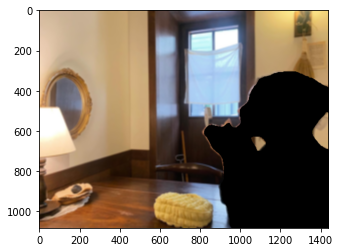

In [111]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur_0, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### 5. Concat & result check

- 나만 Segmenting
    - 탁상과 내 가방, 내가 들고 있는 화장품도 뚜렷하게 보이면 좋겠음
- 내 코끝도 뭉게지듯 경계가 흐려짐

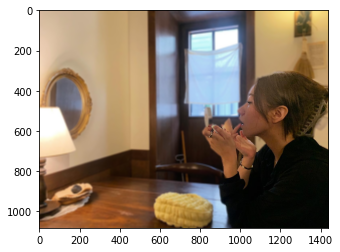

In [112]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur) 
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 2. 사람 아닌 고양이 모드
- **글로벌 클래스 리스트에서 고양이('cat') 인덱스인 8을 하드코딩하여 Color map으로 부터 색상을 얻음**
- 1번인 셀카 아웃포커싱 구현과 플로우는 같음

In [10]:
model = deeplabv3_downlaod()

(1301, 1080, 3)


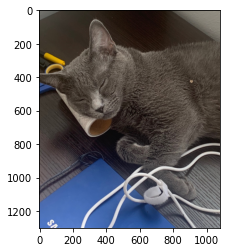

In [122]:
img_path = os.getenv('HOME')+'/aiffel/workplace_1/231005/modulab-AIFELL_Quest/exploration_05/고양이.jpg'  
img_orig = cv2.imread(img_path) 
print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

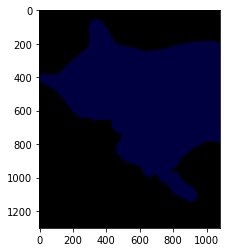

background
cat


In [123]:
segvalues, output = model.segmentAsPascalvoc(img_path)

#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output)
plt.show()

segvalues # segmentAsPascalvoc() 함수를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 배열값을 출력

#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

In [124]:
### 컬러맵 체크
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력
colormap[8] # 고양이 인덱스인 8 (컬러맵 8에 해당하는 배열 출력) 

array([64,  0,  0])

In [125]:
seg_color = (0,0, 64) # 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서

(1301, 1080)


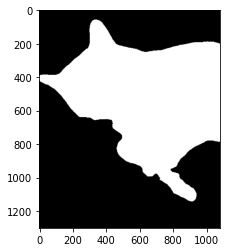

In [126]:
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

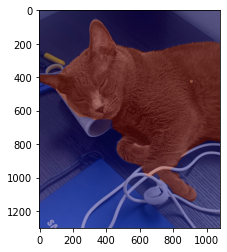

In [127]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = img_orig.copy()

img_mask = seg_map.astype(np.uint8) * 255
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

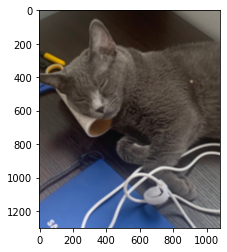

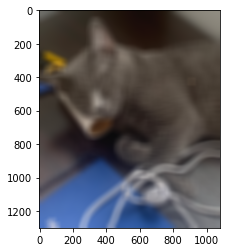

In [128]:
img_orig_blur_0 = cv2.blur(img_orig, (10,10))
img_orig_blur_1 = cv2.blur(img_orig, (50,50))

plt.imshow(cv2.cvtColor(img_orig_blur_0, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img_orig_blur_1, cv2.COLOR_BGR2RGB))
plt.show()

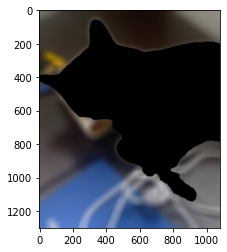

In [129]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg_blur = cv2.bitwise_and(img_orig_blur_1, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

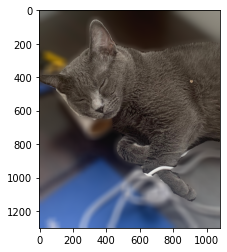

In [130]:
# np.where(조건, 참일때, 거짓일때)
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur) 
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 3. 크로마키 - 배경 합성
- 내 고양이가 내 책상 말고 잔디밭에 누워있으면 더 편할거 같음

#### 함수 설명 
1. ___dlv3_segmentation___(**img_path**, **model**) -> **segvalues**, **output**
    - 모델로 세그멘테이션 수행하여 값을 얻음
    
2. ___Get_seg_backbround___(**segvalues**, **background_image**) -> **img_mask_color**,**img_bg**
    - de seg한 백그라운드 이미지 생성
    - ___get_img_mask___(**segvalues**) -> **img_mask**, **color_mask**
        - 원하는 OBJ의 세그멘테이션 값으로 마스크 생성 
        - ___search_seg_obj_color___(segvalues, obj = 'cat') -> **넘피 컬러값** 
            - 원하는 OBJ의 컬러맵 정보 추출
5. ___synthesis_img_and_seg___(**segvalues**,**img_show**)
    - 세그멘테이션 마스크 값과 원본 이미지 겹쳐서 확인해보기

6. __concat_img___(**img_mask_color,img_bg**)
    - img_mask_color을 보고 np.where로 조건부 출력
    - 즉, 마스크가 되어있으면 (값이 255) origin, 아니면 background의 픽셀을 가져옴 

In [165]:
img_path = os.getenv('HOME')+'/aiffel/workplace_1/231005/modulab-AIFELL_Quest/exploration_05/고양이.jpg'  
img_orig = cv2.imread(img_path) 

# 위에서 다운로드 받는 함수 구현했었음
model = deeplabv3_downlaod()

###### deeplabV3 segmentation
def dlv3_segmentation(img_path, model):
    segvalues, output = model.segmentAsPascalvoc(img_path)
    return segvalues, output # segmentAsPascalvoc() 함수를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 배열값을 출력

segvalues, output = dlv3_segmentation(img_path, model)

In [166]:
###### deeplab seg_color 반환
def search_seg_obj_color(segvalues, obj = 'cat'): # i = segvalues, o = color
    ### 컬러맵 생성 (이해할필요 없음)
    colormap = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype=int)
    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3
    #colormap[:20] #생성한 20개의 컬러맵 출력

    ### segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨 check
    for class_id in segvalues['class_ids']:
        # print(LABEL_NAMES[class_id])
        if LABEL_NAMES[class_id] == obj:
            return colormap[LABEL_NAMES.index(LABEL_NAMES[class_id])]

In [167]:
##### 마스크 반환
def get_img_mask(segvalues):
    # seg_color = (0,0, 64) # 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서
    seg_color = tuple(np.flip(search_seg_obj_color(segvalues)))
    
    # boolean 맵 형성
    seg_map = np.all(output==seg_color, axis=-1) 
    
    # True과 False인 값을 각각 255과 0으로 하여 색상 정보로 인식할 수 있도록 하여 컬러 마스크로 변경
    img_mask = seg_map.astype(np.uint8) * 255
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    
    return img_mask, color_mask

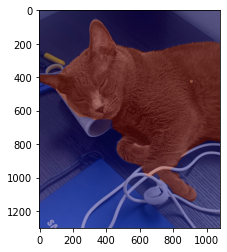

In [168]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
##### 원본 카피
img_show = img_orig.copy()

##### 고양이 모양 마스크와 원본 이미지 겹쳐서 보기
def sinthesis_img_and_seg(segvalues,img_show):
    _, color_mask = get_img_mask(segvalues)
    # 원본 이미지와 마스크를 적당히 합침.
    # 0.6과 0.4는 두 이미지를 섞는 비율.
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0) # 0.6과 0.4는 두 이미지를 섞는 비율입니다.
    return img_show

img_show = sinthesis_img_and_seg(segvalues,img_show)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

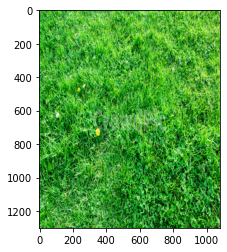

In [169]:
# background load
img_path = os.getenv('HOME')+'/aiffel/workplace_1/231005/modulab-AIFELL_Quest/exploration_05/잔디밭.jpg'  
img_back = cv2.imread(img_path) 
resized_img_back = cv2.resize(img_back, (1080, 1301)) # 고양이 마스크와 크기가 같아야 함
plt.imshow(cv2.cvtColor(resized_img_back, cv2.COLOR_BGR2RGB))

In [170]:
##### de-seg background 생성
def get_seg_background(segvalues, resized_img_back):
    img_mask, _ = get_img_mask(segvalues)
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    #plt.imshow(img_bg_mask)
    #plt.show()
    
    # cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있음
    # 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 obj이 사라지고 배경만 남아요!
    img_bg = cv2.bitwise_and(resized_img_back, img_bg_mask)
    #plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    #plt.show()
    return img_mask_color,img_bg

# get_seg_background(resized_img_back)

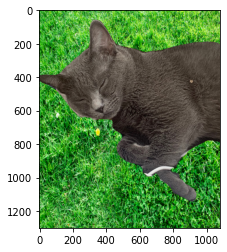

In [172]:
# 합성 사진 결과
def concat_img(img_mask_color,img_bg):
    img_concat = np.where(img_mask_color==255, img_orig, img_bg) # np.where(조건, 참일때, 거짓일때)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()
    
img_mask_color,img_bg = get_seg_background(segvalues,resized_img_back)
concat_img(img_mask_color,img_bg)

## Step 2. 사진에서 문제점 찾기

#### 1. 모델의 Segment 성능 문제
- 디테일한 세그먼테이션이 되지 않음
   - 손과 손사이와 같은 디테일한 영역을 검출하지 못함
   - 부정확한 경계로 인해 코 등이 뭉게짐
- Bottle 은 없으며, Chair는 일부만 검출함
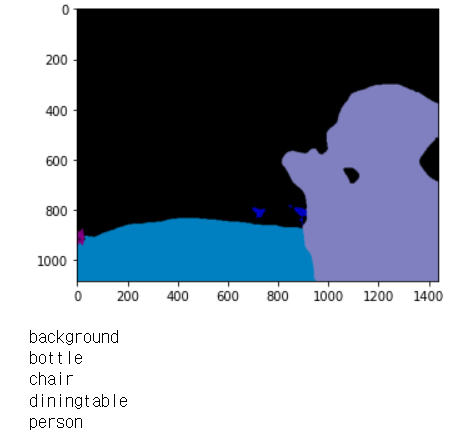

#### 2. 포커싱이 제대로 되지 않음
- 포커싱된 사물의 심도는 깊게 잡을 수 있어야 함
   - 포커싱은 대상도 뚜렷해질 수 있어야함, 포커싱이 제대로 되지 않았다고 볼 수 있음 
- (아래 이미지 설명) 블러를 적게 주었을 때 인물과 배경의 경계가 흐림
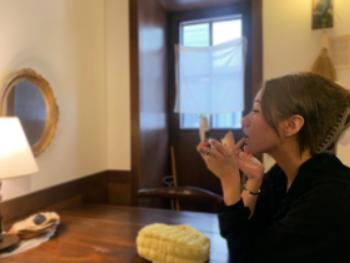

#### 3. 객체 위에 겹쳐지는 객체 탐지 불가
- 크로마키 테스크의 고양이 발 위에 흰 선이 포함됨
- 배경 합성에서 자연스러움을 위해 처리될 필요성이 있음
- (아래 이미지 설명) 발 부분이 부자연스럽게 표현됨
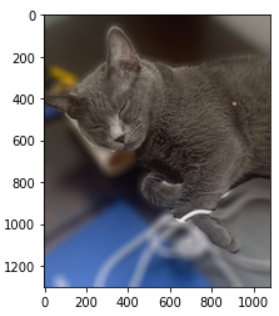

## Step 3. 해결방법 제안

- 딥러닝 아웃포커싱 문제점에 대한 내 생각
    - 블러가 피사체를 중심으로 점진적이지 않음
    - 피사체의 심도가 얖은 경우에 포커싱을 적용하여 심도가 더 깊게 표현될 필요가 있음
    - 포커싱 경계의 처리는 매우 중요함
        - 경계가 섬세하게 세그먼트 되어야할 부분은 명확하게 구별되어야함

#### 1. 문제점 정의
- 엣지 부분이 부정확한 경우 경계선이 피사체 안에 존재하거나 다른 경계도 포함하게 됨
- 가우시안 블러를 얕게 적용하면 포커싱 효과가 뚜렷하지 않을 수 있음

#### 2. 제안하는 해결방법 - 후처리
1. Boundary smoothing: 경계가 불분명한 부분의 처리를 위해 경계선을 스무딩해줌
     - 모든 영역에서 같은 스무딩을 주지 않음
        - Classification 결과값 중 일정 thershold(약 0.6 정도)가 안되는 영역에 대해서는 스무딩을 높게주
        - Classification 결과값이 큰 경우(확실한 경우)에 스무딩을 적게 줌
    
2. 피사체의 depth를 더 깊게 잡은 느낌이 들 수 있도록 화질 개선 보정을 추가
    - 일반적인 샤프닝 필터를 사용하기 보다 업스케일링을 통해 피사체 화질 개선
    - 스케일 피라미드 (Scale Pyramid) 기법을 사용하여 세부 정보를 복원한 정보를 포함한 피사체를 최종적으로 합성
    

## 회고

- 배운점
    - 스마트폰의 인물모드의 트릭을 배웠다. (카메라가 많이 붙어 있는 폰을 사야하는 이유를 몸소 경험할 수 있었다.)
    - 광학에 대해서는 제대로 공부해본 적이 없지만 아웃포커싱을 통해 공부할 수 있었다. 
    - 이미지 세그멘테이션 기법에 대해 학습할 수 있었고, 사용될 수 있는 모델 DeepLab을 배웠다.

- 아쉬운점
    - Unet이나 다른 세그멘테이션 모델을 활용하고 싶었으나 시도해보지 못했음
    - 제안하는 방법을 실험해보지 못했음

- 느낀점
    - 컴퓨터 비전 분야에 관심은 없었지만 생각보다 재밌는 것 같다. 